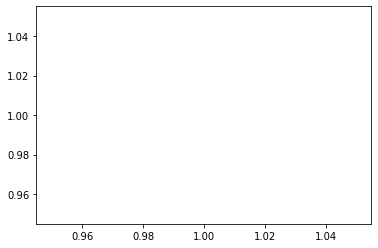

In [1]:
import matplotlib.pyplot as plt

plt.plot([1], [1])

In [2]:
import os

SEED = 42
os.listdir()

['classifier-cross.ipynb', 'curate-108.ipynb']

In [3]:
_local = 'C:/Users/meri2/Documents/PBA/LexicalFeatureBasedClassifier/'
os.chdir(_local)

In [4]:
## Data preparation


from data import load_108
from ml.dataset.feature_dataset import FeatureDataset

Dataframe = load_108()
names = list(Dataframe.columns)[3:]
entries, labels = [], []
for _, row in Dataframe.iterrows():
    labels.append(row['label'])
    entries.append(list(row[names]))

Dataset = FeatureDataset(names, entries, labels)
Dataset.normalize()
Dataset.replace_na(-1.0)
# Dataset.balance(SEED)

Train, Val = Dataset.split(0.6, SEED)

print('For validation set:')
dropped = Val.balance(SEED)
print()

Train.add(*dropped)
print(f"Train size: {len(Train)}\nVal size: {len(Val)}")

For validation set:
Length before balancing: 808
Length after balancing: 246

Train size: 1774
Val size: 246


In [5]:
## Model


from ml.models.featureClassifier import FeatureClassifier

proportions = Train.proportions()
print(f"The proportions of the train set are the following: {proportions}")
weights = 1 - proportions
print(f"Therefore the weights will be: {weights}")

Model = FeatureClassifier(
    number_of_features=Train.number_of_features(), 
    dropout=0.2, 
    weights=weights,
    seed=SEED,
)
Model.cuda()

The proportions of the train set are the following: tensor([0.1088, 0.8912])
Therefore the weights will be: tensor([0.8912, 0.1088])


In [6]:
## Fitting-related objects


from torch.optim import AdamW
from ml.logger import Logger as LoggerClass
from ml.callbacks import Callbacks as CallbacksClass

Optimizer = AdamW(Model.parameters(), lr=5e-05)
Logger = LoggerClass(['train loss', 'train acc', 'val loss', 'val acc'])
Callbacks = CallbacksClass('')
Callbacks.add_early_stopping(
    patience=1000,
    metric_name='Validation Accuracy',
    warmup=100,
)

In [7]:
## Cross training constant arguments


Constant_model_args = {
    'number_of_features' : Train.number_of_features(),
    'weights' : weights,
    'seed' : SEED,  
}

Constant_callbacks_args = {
    'patience' : 100,
    'metric_name' : 'Validation Accuracy',
    'warmup' : 100,
}

Constant_fitting_args = {
    'epochs' : 1000,
    'training_dataset' : Train,
    'validation_dataset' : Val,
    'verbose' : False,
}

In [8]:
## Cross training


from itertools import product

Hidden_sizes = []
Learning_rates = []
Batch_sizes = []
Dropouts = []

Stream = ''

for hidden_size, learning_rate, batch_size, dropout in product(Hidden_sizes, Learning_rates, Batch_sizes, Dropouts):
    # Preparation
    Model = FeatureClassifier(hidden_size=hidden_size, dropout=dropout, **Constant_model_args)
    Model.cuda()
    Optimizer = AdamW(Model.parameters(), lr=learning_rate)
    Logger = LoggerClass(['train loss', 'train acc', 'val loss', 'val acc'])
    Callbacks = CallbacksClass('')
    Callbacks.add_early_stopping(**Constant_callbacks_args)
    # Fit
    Model.fit(
        optimizer=Optimizer, logger=Logger, callbacks=Callbacks,
        batch_size=batch_size,
        **Constant_fitting_args,
    )
    # Logging
    Stream += f"{hidden_size},{learning_rate},{batch_size},{dropout},{max(Logger.metrics['Validation Accuracy'].history)}|"
    print(max(Logger.metrics['Validation Accuracy'].history))
    print('-'*75, end='')

Stream = Stream[:-1]
Stream

''

In [9]:
## First cross-training


import pandas as pd

STREAM = '20,1e05,32,0.1,0.6504065040650406,|,20,1e05,32,0.25,0.5040650406504065,|,20,1e05,32,0.4,0.5040650406504065,|,20,1e05,64,0.1,0.5040650406504065,|,20,1e05,64,0.25,0.5040650406504065,|,20,1e05,64,0.4,0.5040650406504065,|,20,1e05,256,0.1,0.5040650406504066,|,20,1e05,256,0.25,0.5040650406504066,|,20,1e05,256,0.4,0.5040650406504066,|,20,2e05,32,0.1,0.6707317073170732,|,20,2e05,32,0.25,0.6341463414634146,|,20,2e05,32,0.4,0.6626016260162602,|,20,2e05,64,0.1,0.6747967479674797,|,20,2e05,64,0.25,0.6747967479674797,|,20,2e05,64,0.4,0.5040650406504065,|,20,2e05,256,0.1,0.5040650406504066,|,20,2e05,256,0.25,0.5040650406504066,|,20,2e05,256,0.4,0.5040650406504066,|,20,5e05,32,0.1,0.6707317073170732,|,50,1e05,32,0.1,0.6951219512195121,|,50,1e05,32,0.25,0.6951219512195121,|,50,1e05,32,0.4,0.6869918699186992,|,50,1e05,64,0.1,0.6747967479674797,|,50,1e05,64,0.25,0.6747967479674797,|,50,1e05,64,0.4,0.6991869918699187,|,50,1e05,256,0.1,0.5,|,50,1e05,256,0.25,0.6869918699186992,|,50,1e05,256,0.4,0.5,|,50,2e05,32,0.1,0.6951219512195121,|,50,2e05,32,0.25,0.6951219512195121,|,50,2e05,32,0.4,0.6991869918699187,|,50,2e05,64,0.1,0.6991869918699187,|,50,2e05,64,0.25,0.6991869918699187,|,50,2e05,64,0.4,0.6991869918699187,|,50,2e05,256,0.1,0.6747967479674798,|,50,2e05,256,0.25,0.6869918699186992,|,50,2e05,256,0.4,0.6869918699186992,|,50,5e05,32,0.1,0.7235772357723578,|,50,5e05,32,0.25,0.7113821138211383,|,50,5e05,32,0.4,0.7032520325203252,|,50,5e05,64,0.1,0.7235772357723578,|,50,5e05,64,0.25,0.7032520325203252,|,50,5e05,64,0.4,0.6991869918699187,|,50,5e05,256,0.1,0.7032520325203253,|,50,5e05,256,0.25,0.7032520325203253,|,50,5e05,256,0.4,0.7032520325203253,|,100,1e05,32,0.1,0.6707317073170732,|,100,1e05,32,0.25,0.6747967479674797,|,100,1e05,32,0.4,0.6747967479674797,|,100,1e05,64,0.1,0.6707317073170732,|,100,1e05,64,0.25,0.6747967479674797,|,100,1e05,64,0.4,0.6788617886178862,|,100,1e05,256,0.1,0.5,|,100,1e05,256,0.25,0.5,|,100,1e05,256,0.4,0.5,|,100,2e05,32,0.1,0.7032520325203252,|,100,2e05,32,0.25,0.7073170731707317,|,100,2e05,32,0.4,0.6747967479674797,|,100,2e05,64,0.1,0.7073170731707317,|,100,2e05,64,0.25,0.7154471544715447,|,100,2e05,64,0.4,0.6788617886178862,|,100,2e05,256,0.1,0.6707317073170732,|,100,2e05,256,0.25,0.5731707317073171,|,100,2e05,256,0.4,0.5731707317073171,|,100,5e05,32,0.1,0.7154471544715447,|,100,5e05,32,0.25,0.7113821138211383,|,100,5e05,32,0.4,0.7154471544715447,|,100,5e05,64,0.1,0.7073170731707317,|,100,5e05,64,0.25,0.7154471544715447,|,100,5e05,64,0.4,0.7154471544715447,|,100,5e05,256,0.1,0.6707317073170732,|,100,5e05,256,0.25,0.7154471544715448,|,100,5e05,256,0.4,0.6910569105691058,|,250,1e05,32,0.1,0.6747967479674797,|,250,1e05,32,0.25,0.6788617886178862,|,250,1e05,32,0.4,0.6910569105691057,|,250,1e05,64,0.1,0.6788617886178862,|,250,1e05,64,0.25,0.7073170731707317,|,250,1e05,64,0.4,0.6178861788617886,|,250,1e05,256,0.1,0.6178861788617886,|,250,1e05,256,0.25,0.6097560975609757,|,250,1e05,256,0.4,0.5934959349593496,|,250,2e05,32,0.1,0.7113821138211383,|,250,2e05,32,0.25,0.7154471544715447,|,250,2e05,32,0.4,0.7154471544715447,|,250,2e05,64,0.1,0.7235772357723578,|,250,2e05,64,0.25,0.7032520325203252,|,250,2e05,64,0.4,0.7235772357723578,|,250,2e05,256,0.1,0.6788617886178863,|,250,2e05,256,0.25,0.6097560975609757,|,250,2e05,256,0.4,0.7154471544715448,|,250,5e05,32,0.1,0.7195121951219512,|,250,5e05,32,0.25,0.7154471544715447,|,250,5e05,32,0.4,0.7195121951219512,|,250,5e05,64,0.1,0.7195121951219512,|,250,5e05,64,0.25,0.7195121951219512,|,250,5e05,64,0.4,0.7276422764227642,|,250,5e05,256,0.1,0.7235772357723578,|,250,5e05,256,0.25,0.7195121951219513,|,250,5e05,256,0.4,0.7276422764227644,|,'

Saved = pd.DataFrame({key : [] for key in ['Hidden size', 'Learning rate', 'Batch size', 'Dropout', 'Accuracy']})
for x in STREAM.split(',|,'):
    if not x:
        break
    Saved.loc[Saved.shape[0], ['Hidden size', 'Learning rate', 'Batch size', 'Dropout', 'Accuracy']] = \
        [float(y) for y in x.split(',')]

Saved = Saved.sort_values('Accuracy', ascending=False)
Saved.head(10)

,Hidden size,Learning rate,Batch size,Dropout,Accuracy
99,250.0,500000.0,256.0,0.40,0.727642
96,250.0,500000.0,64.0,0.40,0.727642
87,250.0,200000.0,64.0,0.40,0.723577
40,50.0,500000.0,64.0,0.10,0.723577
85,250.0,200000.0,64.0,0.10,0.723577
37,50.0,500000.0,32.0,0.10,0.723577
97,250.0,500000.0,256.0,0.10,0.723577
98,250.0,500000.0,256.0,0.25,0.719512
94,250.0,500000.0,64.0,0.10,0.719512
91,250.0,500000.0,32.0,0.10,0.719512


In [10]:
## Second cross-training


import pandas as pd

STREAM = '200,2e-05,64,0.1,0.7276422764227642|200,2e-05,64,0.3,0.7317073170731707|200,2e-05,64,0.4,0.7317073170731707|200,2e-05,128,0.1,0.7276422764227642|200,2e-05,128,0.3,0.7317073170731707|200,2e-05,128,0.4,0.7317073170731707|200,2e-05,256,0.1,0.7317073170731708|200,2e-05,256,0.3,0.6869918699186992|200,2e-05,256,0.4,0.6585365853658537|200,3e-05,64,0.1,0.7276422764227642|200,3e-05,64,0.3,0.7317073170731707|200,3e-05,64,0.4,0.7317073170731707|200,3e-05,128,0.1,0.7276422764227642|200,3e-05,128,0.3,0.7317073170731707|200,3e-05,128,0.4,0.7357723577235772|200,3e-05,256,0.1,0.7317073170731708|200,3e-05,256,0.3,0.7357723577235773|200,3e-05,256,0.4,0.7357723577235773|200,5e-05,64,0.1,0.7317073170731707|200,5e-05,64,0.3,0.7317073170731707|200,5e-05,64,0.4,0.7317073170731707|200,5e-05,128,0.1,0.7357723577235772|200,5e-05,128,0.3,0.7317073170731707|200,5e-05,128,0.4,0.7317073170731707|200,5e-05,256,0.1,0.7357723577235773|200,5e-05,256,0.3,0.7317073170731708|200,5e-05,256,0.4,0.7357723577235773|250,2e-05,64,0.1,0.7154471544715447|250,2e-05,64,0.3,0.7154471544715447|250,2e-05,64,0.4,0.7276422764227642|250,2e-05,128,0.1,0.6788617886178862|250,2e-05,128,0.3,0.7113821138211383|250,2e-05,128,0.4,0.7276422764227642|250,2e-05,256,0.1,0.6788617886178863|250,2e-05,256,0.3,0.6097560975609757|250,2e-05,256,0.4,0.6097560975609757|250,3e-05,64,0.1,0.7195121951219512|250,3e-05,64,0.3,0.7113821138211383|250,3e-05,64,0.4,0.7235772357723578|250,3e-05,128,0.1,0.7235772357723578|250,3e-05,128,0.3,0.7154471544715447|250,3e-05,128,0.4,0.7276422764227642|250,3e-05,256,0.1,0.6951219512195123|250,3e-05,256,0.3,0.6747967479674798|250,3e-05,256,0.4,0.7276422764227644|250,5e-05,64,0.1,0.7195121951219512|250,5e-05,64,0.3,0.7235772357723578|250,5e-05,64,0.4,0.7276422764227642|250,5e-05,128,0.1,0.7195121951219512|250,5e-05,128,0.3,0.7195121951219512|250,5e-05,128,0.4,0.7276422764227642|250,5e-05,256,0.1,0.7235772357723578|250,5e-05,256,0.3,0.7317073170731708|250,5e-05,256,0.4,0.7276422764227644|300,2e-05,64,0.1,0.7276422764227642|300,2e-05,64,0.3,0.7317073170731707|300,2e-05,64,0.4,0.7032520325203252|300,2e-05,128,0.1,0.7276422764227642|300,2e-05,128,0.3,0.7073170731707317|300,2e-05,128,0.4,0.7032520325203252|300,2e-05,256,0.1,0.6869918699186992|300,2e-05,256,0.3,0.7032520325203253|300,2e-05,256,0.4,0.7073170731707318|300,3e-05,64,0.1,0.7276422764227642|300,3e-05,64,0.3,0.7317073170731707|300,3e-05,64,0.4,0.7276422764227642|300,3e-05,128,0.1,0.7317073170731707|300,3e-05,128,0.3,0.7154471544715447|300,3e-05,128,0.4,0.7073170731707317|300,3e-05,256,0.1,0.7195121951219513|300,3e-05,256,0.3,0.7073170731707318|300,3e-05,256,0.4,0.7073170731707318|300,5e-05,64,0.1,0.7276422764227642|300,5e-05,64,0.3,0.7276422764227642|300,5e-05,64,0.4,0.7317073170731707|300,5e-05,128,0.1,0.7276422764227642|300,5e-05,128,0.3,0.7276422764227642|300,5e-05,128,0.4,0.7276422764227642|300,5e-05,256,0.1,0.7235772357723578|300,5e-05,256,0.3,0.7113821138211383|300,5e-05,256,0.4,0.7073170731707318'
Saved = pd.DataFrame({key : [] for key in ['Hidden size', 'Learning rate', 'Batch size', 'Dropout', 'Accuracy']})
for x in STREAM.split('|'):
    if not x:
        break
    Saved.loc[Saved.shape[0], ['Hidden size', 'Learning rate', 'Batch size', 'Dropout', 'Accuracy']] = \
        [float(y) for y in x.split(',')]

Saved = Saved.sort_values('Accuracy', ascending=False)
Saved.head(10)

,Hidden size,Learning rate,Batch size,Dropout,Accuracy
17,200.0,0.00003,256.0,0.4,0.735772
26,200.0,0.00005,256.0,0.4,0.735772
24,200.0,0.00005,256.0,0.1,0.735772
16,200.0,0.00003,256.0,0.3,0.735772
21,200.0,0.00005,128.0,0.1,0.735772
14,200.0,0.00003,128.0,0.4,0.735772
25,200.0,0.00005,256.0,0.3,0.731707
6,200.0,0.00002,256.0,0.1,0.731707
52,250.0,0.00005,256.0,0.3,0.731707
15,200.0,0.00003,256.0,0.1,0.731707


In [11]:
## Third cross-training


import pandas as pd

STREAM = '175,3e-05,128,0.1,0.7032520325203252|175,3e-05,128,0.4,0.7235772357723578|175,3e-05,128,0.5,0.6869918699186992|175,3e-05,256,0.1,0.7032520325203253|175,3e-05,256,0.4,0.6991869918699187|175,3e-05,256,0.5,0.6382113821138212|175,3e-05,512,0.1,0.6626016260162603|175,3e-05,512,0.4,0.6341463414634148|175,3e-05,512,0.5,0.6422764227642277|175,4e-05,128,0.1,0.7154471544715447|175,4e-05,128,0.4,0.7276422764227642|175,4e-05,128,0.5,0.7276422764227642|175,4e-05,256,0.1,0.7032520325203253|175,4e-05,256,0.4,0.7276422764227644|175,4e-05,256,0.5,0.6869918699186992|175,4e-05,512,0.1,0.7032520325203253|175,4e-05,512,0.4,0.6341463414634148|175,4e-05,512,0.5,0.6382113821138212|175,5e-05,128,0.1,0.7154471544715447|175,5e-05,128,0.4,0.7276422764227642|175,5e-05,128,0.5,0.7276422764227642|175,5e-05,256,0.1,0.7032520325203253|175,5e-05,256,0.4,0.7235772357723578|175,5e-05,256,0.5,0.6869918699186992|175,5e-05,512,0.1,0.7032520325203253|175,5e-05,512,0.4,0.6991869918699187|175,5e-05,512,0.5,0.6422764227642277|200,3e-05,128,0.1,0.7276422764227642|200,3e-05,128,0.4,0.7357723577235772|200,3e-05,128,0.5,0.7357723577235772|200,3e-05,256,0.1,0.7357723577235773|200,3e-05,256,0.4,0.7357723577235773|200,3e-05,256,0.5,0.6707317073170732|200,3e-05,512,0.1,0.7113821138211383|200,3e-05,512,0.4,0.7357723577235773|200,3e-05,512,0.5,0.6747967479674798|200,4e-05,128,0.1,0.7276422764227642|200,4e-05,128,0.4,0.7317073170731707|200,4e-05,128,0.5,0.7317073170731707|200,4e-05,256,0.1,0.7357723577235773|200,4e-05,256,0.4,0.7357723577235773|200,4e-05,256,0.5,0.7357723577235773|200,4e-05,512,0.1,0.7357723577235773|200,4e-05,512,0.4,0.6585365853658537|200,4e-05,512,0.5,0.6626016260162603|200,5e-05,128,0.1,0.7276422764227642|200,5e-05,128,0.4,0.7357723577235772|200,5e-05,128,0.5,0.7357723577235772|200,5e-05,256,0.1,0.7317073170731708|200,5e-05,256,0.4,0.7357723577235773|200,5e-05,256,0.5,0.7357723577235773|200,5e-05,512,0.1,0.7357723577235773|200,5e-05,512,0.4,0.7357723577235773|200,5e-05,512,0.5,0.6626016260162603|225,3e-05,128,0.1,0.6951219512195121|225,3e-05,128,0.4,0.6910569105691057|225,3e-05,128,0.5,0.6910569105691057|225,3e-05,256,0.1,0.6951219512195123|225,3e-05,256,0.4,0.6869918699186992|225,3e-05,256,0.5,0.6910569105691058|225,3e-05,512,0.1,0.6951219512195123|225,3e-05,512,0.4,0.6910569105691058|225,3e-05,512,0.5,0.6869918699186992|225,4e-05,128,0.1,0.7032520325203252|225,4e-05,128,0.4,0.6869918699186992|225,4e-05,128,0.5,0.6910569105691057|225,4e-05,256,0.1,0.6951219512195123|225,4e-05,256,0.4,0.6910569105691058|225,4e-05,256,0.5,0.6869918699186992|225,4e-05,512,0.1,0.6951219512195123|225,4e-05,512,0.4,0.6910569105691058|225,4e-05,512,0.5,0.6910569105691058|225,5e-05,128,0.1,0.7235772357723578|225,5e-05,128,0.4,0.6910569105691057|225,5e-05,128,0.5,0.6910569105691057|225,5e-05,256,0.1,0.6910569105691058|225,5e-05,256,0.4,0.6910569105691058|225,5e-05,256,0.5,0.6910569105691058|225,5e-05,512,0.1,0.6869918699186992|225,5e-05,512,0.4,0.6910569105691058|225,5e-05,512,0.5,0.6910569105691058'
Saved = pd.DataFrame({key : [] for key in ['Hidden size', 'Learning rate', 'Batch size', 'Dropout', 'Accuracy']})
for x in STREAM.split('|'):
    if not x:
        break
    Saved.loc[Saved.shape[0], ['Hidden size', 'Learning rate', 'Batch size', 'Dropout', 'Accuracy']] = \
        [float(y) for y in x.split(',')]

Saved = Saved.sort_values('Accuracy', ascending=False)
Saved.head(10)


,Hidden size,Learning rate,Batch size,Dropout,Accuracy
40,200.0,0.00004,256.0,0.4,0.735772
51,200.0,0.00005,512.0,0.1,0.735772
42,200.0,0.00004,512.0,0.1,0.735772
41,200.0,0.00004,256.0,0.5,0.735772
30,200.0,0.00003,256.0,0.1,0.735772
50,200.0,0.00005,256.0,0.5,0.735772
49,200.0,0.00005,256.0,0.4,0.735772
52,200.0,0.00005,512.0,0.4,0.735772
31,200.0,0.00003,256.0,0.4,0.735772
34,200.0,0.00003,512.0,0.4,0.735772


In [12]:
## Fourth cross-training


import pandas as pd

STREAM = '190,4e-05,256,0.1,0.7317073170731708|190,4e-05,256,0.4,0.7235772357723578|190,4e-05,512,0.1,0.7317073170731708|190,4e-05,512,0.4,0.6829268292682927|195,4e-05,256,0.1,0.7073170731707318|195,4e-05,256,0.4,0.7154471544715448|195,4e-05,512,0.1,0.7073170731707318|195,4e-05,512,0.4,0.7073170731707318|200,4e-05,256,0.1,0.7317073170731708|200,4e-05,256,0.4,0.7357723577235773|200,4e-05,512,0.1,0.7317073170731708|200,4e-05,512,0.4,0.6544715447154472|205,4e-05,256,0.1,0.7276422764227644|205,4e-05,256,0.4,0.7195121951219513|205,4e-05,512,0.1,0.7276422764227644|205,4e-05,512,0.4,0.7195121951219513|210,4e-05,256,0.1,0.7113821138211383|210,4e-05,256,0.4,0.7073170731707318|210,4e-05,512,0.1,0.7113821138211383|210,4e-05,512,0.4,0.7073170731707318'
Saved = pd.DataFrame({key : [] for key in ['Hidden size', 'Learning rate', 'Batch size', 'Dropout', 'Accuracy']})
for x in STREAM.split('|'):
    if not x:
        break
    Saved.loc[Saved.shape[0], ['Hidden size', 'Learning rate', 'Batch size', 'Dropout', 'Accuracy']] = \
        [float(y) for y in x.split(',')]

Saved = Saved.sort_values('Accuracy', ascending=False)
Saved.head(10)

,Hidden size,Learning rate,Batch size,Dropout,Accuracy
9,200.0,0.00004,256.0,0.4,0.735772
0,190.0,0.00004,256.0,0.1,0.731707
8,200.0,0.00004,256.0,0.1,0.731707
10,200.0,0.00004,512.0,0.1,0.731707
2,190.0,0.00004,512.0,0.1,0.731707
12,205.0,0.00004,256.0,0.1,0.727642
14,205.0,0.00004,512.0,0.1,0.727642
1,190.0,0.00004,256.0,0.4,0.723577
13,205.0,0.00004,256.0,0.4,0.719512
15,205.0,0.00004,512.0,0.4,0.719512


In [13]:
## Best fitting arguments


Hidden_size = 200
Learning_rate = 4e-5
Batch_size = 256
Dropout = 0.4

In [14]:
## Fitting preparation


Model_args = {
    'hidden_size' : Hidden_size,
    'dropout' : Dropout,
    'number_of_features' : Train.number_of_features(),
    'weights' : 1 - Train.proportions(),
    'seed' : SEED,  
}

Callbacks_args = {
    'patience' : 500,
    'metric_name' : 'Validation Accuracy',
    'warmup' : 100,
}

Fitting_args = {
    'epochs' : 10000,
    'batch_size' : Batch_size,
    'training_dataset' : Train,
    'validation_dataset' : Val,
    'verbose' : False,
    'seed' : 42,
}

Model = FeatureClassifier(**Model_args)
Model.cuda()

Optimizer = AdamW(Model.parameters(), lr=Learning_rate)

Logger = LoggerClass(['train loss', 'train acc', 'val loss', 'val acc'])

Callbacks = CallbacksClass('')
Callbacks.add_early_stopping(**Callbacks_args)

0.7560975609756099


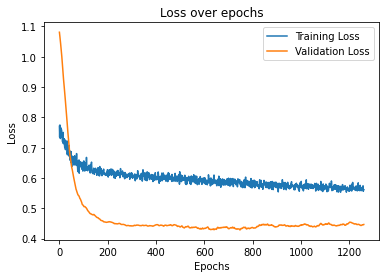

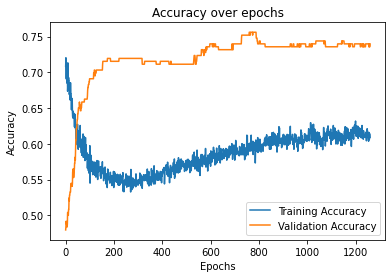

In [15]:
## Extended fitting


Model.fit(
    optimizer=Optimizer, logger=Logger, callbacks=Callbacks,
    **Fitting_args,
)

print(max(Logger.metrics['Validation Accuracy'].history))

Logger.plot('loss')
Logger.plot('accuracy')